In [126]:
# Import Required Packages
import torch
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap


In [127]:
def plot_arc_input_outputs(input_outputs, column_headings=None, figsize_multiplier=2, show_grid=False, title_fontsize=8):
    """
    A more compact version of the plot function.
    
    Parameters:
    - input_outputs: List of lists where each element is either a 2D numpy array or (2D_array, mask).
    - column_headings: Optional list of column headings.
    - figsize_multiplier: Scale down the figure size. Default 2 means smaller than original 5.
    - show_grid: Whether to show grid lines. Default False for a cleaner, smaller plot.
    - title_fontsize: Font size for titles.
    """
    column_headings = column_headings or ["input", "output"]
    n_pairs = len(input_outputs)
    n_cols = len(input_outputs[0])

    # Create a smaller figure
    figure, axs = plt.subplots(n_pairs, n_cols, figsize=(figsize_multiplier * n_cols, figsize_multiplier * n_pairs), dpi=100)

    # Ensure axs is always 2D
    if n_pairs == 1 and n_cols == 1:
        axs = np.array([[axs]])
    elif n_pairs == 1:
        axs = axs[np.newaxis, :]
    elif n_cols == 1:
        axs = axs[:, np.newaxis]

    # Define colors
    colors_rgb = {
        0: (0x00, 0x00, 0x00),
        1: (0x00, 0x74, 0xD9),
        2: (0xFF, 0x41, 0x36),
        3: (0x2E, 0xCC, 0x40),
        4: (0xFF, 0xDC, 0x00),
        5: (0xA0, 0xA0, 0xA0),
        6: (0xF0, 0x12, 0xBE),
        7: (0xFF, 0x85, 0x1B),
        8: (0x7F, 0xDB, 0xFF),
        9: (0x87, 0x0C, 0x25),
        10: (0xFF, 0xFF, 0xFF)
    }

    _float_colors = [tuple(c / 255 for c in col) for col in colors_rgb.values()]
    arc_cmap = ListedColormap(_float_colors)

    for ex, input_output in enumerate(input_outputs):
        for col, grid in enumerate(input_output):
            ax = axs[ex, col]

            # Handle partial output case
            extra_title = ""
            if isinstance(grid, tuple) and len(grid) == 2 and isinstance(grid[0], np.ndarray):
                grid, mask = grid
                grid = grid.copy()
                if isinstance(mask, np.ndarray):
                    grid[~mask] = 10
                else:
                    grid[grid==mask] = 10
                extra_title = " partial output"
            elif not isinstance(grid, np.ndarray):
                # If it's not a numpy array or tuple as expected, skip
                continue

            grid = grid.T

            # Use pcolormesh to plot
            ax.pcolormesh(
                grid,
                cmap=arc_cmap,
                rasterized=True,
                vmin=0,
                vmax=10,
            )
            
            # Optionally show grid and ticks
            if show_grid:
                ax.set_xticks(np.arange(0, grid.shape[1]+1, 1))
                ax.set_yticks(np.arange(0, grid.shape[0]+1, 1))
                ax.grid(True, which='both')
            else:
                ax.set_xticks([])
                ax.set_yticks([])
                ax.grid(False)

            ax.set_aspect('equal')
            ax.invert_yaxis()

            if col < len(column_headings):
                ax.set_title(column_headings[col] + extra_title, fontsize=title_fontsize)
            else:
                ax.set_title(extra_title, fontsize=title_fontsize)

    plt.tight_layout()
    plt.show()


In [128]:
from transformers import pipeline

# Set environment variable
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Clear CUDA cache
import torch
torch.cuda.empty_cache()

# Initialize pipeline
pipe = pipeline("text-generation", model="barc0/Llama-3.1-ARC-Heavy-Induction-8B", device=0)

# Input message
response = pipe("Who are you?")
print(response)


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]
/home/jdelinea/anaconda3/envs/BarcHandbook/lib/python3.10/site-packages/transformers/generation/utils.py:1233: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'Who are you? I am a 5th generation native of the area, and my family'}]


In [129]:
# Load Required Datasets
from datasets import load_dataset
ds = load_dataset("barc0/200k_HEAVY_gpt4o-description-gpt4omini-code_generated_problems")

ds

DatasetDict({
    train: Dataset({
        features: ['source', 'examples', 'seeds'],
        num_rows: 199728
    })
})

## Summary Findings

On the 200k data set, 

- There is between 1 to 6 concepts per mutated seed.
- Which gives 8430 unique concepts for 400'000 examples. 
- The distribution of the concepts are not uniform. Some only appear once. Only 7 appear more than 10'000 times, and 83 appear more than 1'000 times.

The ones that appear more than 1 every 40 examples are,

- color transformation    31052
- object detection        22492
- rotation                14447
- symmetry                14274
- filling                 13888
- color change            12092
- color mapping           10970

As we can see, they are quite obscure as we struggle to understand the difference between, color transformation, change and mapping.

Explainations could be intentional or unintentional 

- unintentional: ChatGPT stochastic sampling of words usage increasing the vocabulary. 
- intentional: The need to consistently refine the vocabulary when encountering new examples, but even if its intentional it might not be desired.




---------------

Therefore we decided to group them in more abstract categories, the titles are 

- Geometric and Spatial Transformations
- Pattern and Structure Analysis
- Shape, Boundary, and Line Features
- Color Operations and Transformations
- Pixel-Level Operations
- Object-Level Operations
- High-Level Spatial Interactions and Relations
- Measurement and Counting

For example in Geometric and Spatial Transformations we have, 

     "translation", "rotation", "reflection", "mirroring", "flipping", 
        "scaling", "alignment", "positioning", "shape transformation", 
        "symmetry", "symmetry detection", "translational symmetry", 
        "rotational symmetry", "grid transformation", "grid manipulation"

Our intentions to classify are twofolds,

- Help our Agent to reason, the concepts make the tasks more granular. We hold the assumption that as in the brain, intelligence comes from a composition of different parts, with their own specialization. Under this lens, it becomes evident that observing and finding a conveniant representation is quite different proceess than having to output y_test for x_test.
- Augment the dataset. If the categories are well defined, they should inform us the equivariant transformations for the examples.


In [130]:
# Example categories dictionary from previous organization
categories = {
    "Geometric_and_Spatial_Transformations": [
        "translation", "rotation", "reflection", "mirroring", "flipping", 
        "scaling", "alignment", "positioning", "shape transformation", 
        "symmetry", "symmetry detection", "translational symmetry", 
        "rotational symmetry", "grid transformation", "grid manipulation"
    ],
    "Pattern_and_Structure_Analysis": [
        "pattern generation", "pattern extraction", "pattern recognition", 
        "pattern detection", "pattern replication", "pattern expansion", 
        "pattern completion", "geometric pattern", "connected components", 
        "connectivity", "topology", "connection"
    ],
    "Shape_Boundary_and_Line_Features": [
        "shape detection", "boundary detection", "border detection", 
        "interior detection", "line drawing", "lines", "diagonal lines"
    ],
    "Color_Operations_and_Transformations": [
        "color transformation", "color change", "color mapping", "color shifting",
        "color inversion", "color replacement", "color correspondence", 
        "color filling", "color blending", "color propagation", "color swapping", 
        "coloring", "color merging", "color expansion", "color detection", 
        "color extraction", "color matching", "color counting"
    ],
    "Pixel_Level_Operations": [
        "pixel manipulation", "pixel transformation", "pixel patterns", 
        "pixel expansion", "filling", "flood fill"
    ],
    "Object_Level_Operations": [
        "object detection", "object extraction", "objects", "object manipulation", 
        "object placement", "object positioning", "bounding box", "bounding boxes"
    ],
    "High_Level_Spatial_Interactions_and_Relations": [
        "collision", "collision detection", "contact", "contact detection", 
        "occlusion", "layering", "stacking", "merging", "surrounding", "attraction"
    ],
    "Measurement_and_Counting": [
        "counting", "area calculation"
    ]
}


Asked ChatGPT to map each of the 8430 concepts to one category. The performance is slightly better but not linearly.

Points are, 

- Some terms are ambivalent: "cornor color selection" or "object recoloring", they could fit multiple categories.
- Sometimes ankward words choosing: "merging colors at a global scale". Can it be explained in simplier/atomic words ? 
- This only represents 310 of the 8430 concepts!

In [131]:
categories0 = {
    "Pixel-Level Operations": [
        "pixel-level operations", "pixel positioning", "pixel flipping", "pixel shifting",
        "pixel swapping", "pixel duplication", "pixel pattern generation", "pixel pattern replication",
        "pixel rotation", "pixel reflection", "pixel alignment", "pixel arrangement", "pixel adjacency",
        "pixel color mixing", "pixel inversion", "pixel counting", "pixel masking", "pixel dropping",
        "pixel extending", "pixel gradient", "pixel replacement", "pixel classification", "pixel averaging",
        "pixel clusters", "pixel compression", "pixel movement", "pixel propagation", "pixel pattern sliding",
        "pixel pattern inversion", "pixel connectivity", "pixel grid transformations", "pixel intersection",
        "pixel selection", "pixel distribution", "pixel mapping", "pixel pattern manipulation", 
        "pixel pattern scaling", "pixel rearrangement", "pixel pattern rotation", "pixel merging", 
        "pixel pattern extraction", "pixel pattern growth", "pixel pattern duplication", "pixel flipping vertically",
        "pixel flipping horizontally", "pixelation", "pixel shading", "pixel thresholding", "pixel frequency",
        "pixel pattern formation", "pixel pattern recognition", "pixel bridging", "pixel bouncing", "pixel grouping",
        "pixel intensity", "pixel contraction", "pixel spiraling", "pixel scaling"
    ],

    "Color Operations and Transformations": [
        "color assignment", "color sorting", "color patterns", "color averaging", "color grouping",
        "color alternation", "color manipulation", "color rotation", "color preservation", "color proximity",
        "color indicators", "color filtering", "color mixing", "color gradient", "color guide", "color sequence",
        "color alignment", "color recognition", "color categorization", "color modification", "color pattern recognition",
        "color gradient generation", "color representation", "color separation", "color changing", "output color mapping",
        "alignment by color", "color sequence growth", "color flipping", "background preservation", "color spread",
        "color-based selection", "color swapping", "color cycling", "color complement", "color inversion",
        "color shading", "color merging", "color blending", "color quantization", "color indexing",
        "color thresholding", "color wave", "color restoration", "color switching", "color infiltration",
        "color density", "color arrangement in sequences", "color interlacing", "color flipping horizontally/vertically",
        "monochromatic patterns", "recoloring", "color intensity adjustment", "hue/saturation/brightness transformations",
        "color reflection", "color boundaries", "alpha compositing", "color classification", "color counting",
        "grayscale conversion", "majority/minority color detection", "color frequency analysis", "color conversion"
    ],

    "Shape, Boundary, and Line Features": [
        "shape alignment", "shape flipping", "shape filling", "shape recognition", "shape extraction", "shape scaling",
        "shape merging", "shape expansion", "shape rotation", "shape completion", "shape finding", "shape identification",
        "shape matching", "shape mapping", "shape counting", "shape mirroring", "shape replacement", "shape retention",
        "shape arrangement", "shape overlapping", "shape boundary detection", "shape area calculation", "shape resizing",
        "shape classification", "shape morphing", "shape adjacency", "shape combination", "shape separation",
        "shape intersection", "shape generation", "shape outlines", "shape simplification", "geometric shapes",
        "edge detection", "edge alignment", "edge proximity", "boundary filling", "boundary expansion", "boundary coloring",
        "boundary interaction", "boundary manipulation", "boundary tracing", "boundary conditions", "boundary rules",
        "boundary reflection", "boundary recognition", "boundary extension", "boundary growth", "line detection",
        "line extension", "line drawing", "line replication", "line thickness", "line orientation", "line patterns",
        "edge counting", "bounding box detection", "bounding box manipulation", "bounding box extraction",
        "polygon detection", "polygon filling", "corners", "corner detection", "corner color selection",
        "rectangular shapes", "rectangular cells", "rectangular filling", "rectangular patterns",
        "circle detection", "concentric circles", "star shape detection", "diamond pattern generation",
        "diagonal lines", "diagonal pattern", "diagonal reflection", "diagonal expansion", "zigzag pattern/lines",
        "stripe detection", "checkered pattern"
    ],

    "Pattern and Structure Analysis & Generation": [
        "pattern scaling", "pattern shifting", "pattern transformation", "pattern recognition", "pattern manipulation",
        "pattern placement", "pattern drawing", "pattern rotation", "pattern reflection", "pattern matching",
        "pattern reconstruction", "pattern inversion", "pattern symmetry", "pattern mirroring", "pattern replacement",
        "pattern creation", "pattern distribution", "pattern frequency", "symmetrical pattern generation", "fractal patterns",
        "pattern insertion", "pattern formation", "pattern distortion", "pattern continuity", "repeating patterns",
        "pattern flipping", "pattern extension", "pattern translation", "checkerboard pattern", "geometric pattern generation",
        "spiral pattern", "wave pattern", "diagonal pattern extraction", "radial pattern", "pyramid pattern",
        "square pattern generation", "pattern growth", "pattern repetition", "pattern tiling", "pattern adaptation",
        "pattern complexity", "pattern merging", "pattern layering", "pattern isolation", "pattern weaving", "pattern detection",
        "pattern synergy", "periodic patterns", "pattern modeling", "pattern association", "pattern nesting"
    ],

    "Geometric and Spatial Transformations": [
        "transformation", "geometric manipulation", "geometric pattern generation", "radial expansion", "radial symmetry",
        "mirror symmetry", "vertical reflection", "horizontal lines/vertical lines (transformations)", "vertical flipping",
        "horizontal flipping", "diagonal reflection", "mirror", "resizing", "area filling (geometric)", "shape scaling",
        "grid transformations", "grid rotation", "geometric transformation", "rotation transformation",
        "rotation around a pivot", "scaling", "shape flipping", "shape manipulation", "geometric distortion",
        "repositioning", "symmetrical transformation", "rotate", "translation (up/down/left/right)", "flipping objects",
        "diagonal transformation", "inversion", "reflection across axes", "shifting", "shear", "skew", "morphing",
        "uniform scaling", "radial transformations", "repeating transformations", "rotating patterns", "rotating objects",
        "axis reflection", "perspective transformations", "rotational symmetry detection", "dimension expanding/reducing",
        "warp"
    ],

    "Object-Level Operations": [
        "object merging", "obstacle avoidance", "object-level operations", "object splitting", "object size",
        "object counting", "object detection", "object expansion", "object size comparison", "object scaling",
        "object matching", "object rotation", "object transformation", "object alignment", "object arrangement",
        "object overlay", "object separation", "object recognition", "object growing", "object blitting", "object identification",
        "object duplication", "object shrinking", "object flipping", "object replacement", "object movement", "object classification",
        "object stack", "object shape detection", "object segmentation", "object recoloring", "object boundary detection",
        "object scaling and translation", "object rearrangement", "object union", "object extension", "object resizing",
        "object removal", "merging objects", "object shape transformation", "connected component detection", "cluster detection",
        "largest object detection", "component merging", "connected component merging", "object partitioning", "object shape mapping",
        "largest component", "puzzle pieces (object-level puzzle fitting)", "shape cropping", "morphological operations (object scale)",
        "object relocation", "object layering", "object reflection"
    ],

    "High-Level Spatial Interactions, Relations & Arrangement": [
        "adjacency", "path finding", "overlapping", "arrangement", "spatial arrangement", "top-down growth", "radial growth",
        "bouncing", "gravity", "direction", "growing", "neighborhood analysis", "spreading", "background handling",
        "masks", "intersection", "layering", "overlaying", "merging colors at a global scale", "object adjacency transformations",
        "background replacement", "mosaic creation", "puzzle piece arrangement", "topological transformations", "orientation detection",
        "collisions between shapes/objects", "symmetrical expansions across the entire field", "reflection and symmetrical patterns in environment",
        "path coloring", "neighbor counting", "position-based transformations (global)", "tile transformations", "layering patterns",
        "arrangement in layers", "slicing grids", "bridging and connecting shapes"
    ],

    "Measurement, Counting & Mapping": [
        "height mapping", "largest area", "measurement and counting", "centroid calculation", "area coverage", "distance", "area",
        "region counting", "counting", "size measurement", "perimeter calculation", "distance mapping", "area comparison", "object size",
        "area filling", "majority vote", "counting occurrences", "size-based rules", "size classification", "size comparison", "sorting by size",
        "counting colors", "frequency counting", "counting intersections", "largest object", "histogram", "radius measurement",
        "counting unique colors", "size determination", "distance measurement", "largest component detection", "dimension detection",
        "angle detection", "center calculation", "bounding box calculation", "width measurement", "majority color filling", "thresholding",
        "counting bends", "number of connected components", "complexity measurement", "frequency sorting", "intensity sorting", "counting enclosed areas",
        "line length measurement", "largest cluster identification", "classification by size", "unique color detection", "horizontal/vertical line counting",
        "positional mapping", "indexing", "coordinate mapping", "area scaling", "mapping rules", "size filtering", "cluster analysis"
    ]
}


# Statistical Analysis of the behavior of the Concepts in the 200k Dataset

Extract Concepts from each examples

In [132]:
# Retrieve list of list of concepts for each task
n = len(ds["train"])

# Compile the regex once for efficiency
concepts_pattern = re.compile(r"# concepts:\n# (.+)")

# Optimized function
def ExtractConcepts(text):
    """Extracts concepts from a string using a precompiled regex."""
    concepts_match = concepts_pattern.search(text)
    return concepts_match.group(1).strip().split(", ") if concepts_match else []

# Assuming `ds["train"]["source"]` is a list-like object
list_concepts = [
    ExtractConcepts(source) for source in ds["train"]["source"][:n]
]

# Generate PandaFrame for each examples, with the maxmimum number of concepts in a single example (6)
pd_concepts = pd.DataFrame(list_concepts, columns = ["Concept_1", "Concept_2", "Concept_3","Concept_4","Concept_5","Concept_6"])

# add column of index
pd_concepts["Index"] = range(1,n+1)

# Display Columns
print(pd_concepts.shape)
pd_concepts.head(5)


(199728, 7)


,Concept_1,Concept_2,Concept_3,Concept_4,Concept_5,Concept_6,Index
0,pattern detection,color replacement,None,None,None,None,1
1,sorting,height mapping,color assignment,None,None,None,2
2,overlapping,color transformation,object manipulation,None,None,None,3
3,reflection,color patterns,mirroring,None,None,None,4
4,filling regions,color transformation,adjacency,None,None,None,5


### First Analysis, without grouping concepts per categories

In [133]:
# Generate Melted data frame
pd_concepts_melted = pd_concepts.melt(id_vars="Index", value_vars=["Concept_1", "Concept_2", "Concept_3", "Concept_4", "Concept_5", "Concept_6"],var_name="Co",value_name= "Concept")

# Drop rows with "None" Concept
pd_concepts_melted = pd_concepts_melted.dropna(subset="Concept")

# Print total number of concepts: sum_{example}: #concept per example
print(f"The total number of (repeating) concepts in the 200k data set is {pd_concepts_melted.shape[0]}.")

# Count the total number of concept
count_concept = pd_concepts_melted["Concept"].value_counts()
print(f"There is a total of {len(count_concept)} concepts for 400'000 examples.")

# Keep list of concepts appearing at least 1 every 400 examples
reduced_count_concept = count_concept[count_concept > 1000]
print(f"There is a total of {len(reduced_count_concept)} concepts shown in more than 1'000 examples in 200'000 examples.")

# Keep list of concepts appearing at least 1 every 40 examples
reduced_count_concept2 = count_concept[count_concept > 10000]
print(f"There is a total of {len(reduced_count_concept2)} concepts shown in more than 10'000 examples in 200'000 examples.")

The total number of (repeating) concepts in the 200k data set is 520796.
There is a total of 8430 concepts for 400'000 examples.
There is a total of 83 concepts shown in more than 1'000 examples in 200'000 examples.
There is a total of 7 concepts shown in more than 10'000 examples in 200'000 examples.


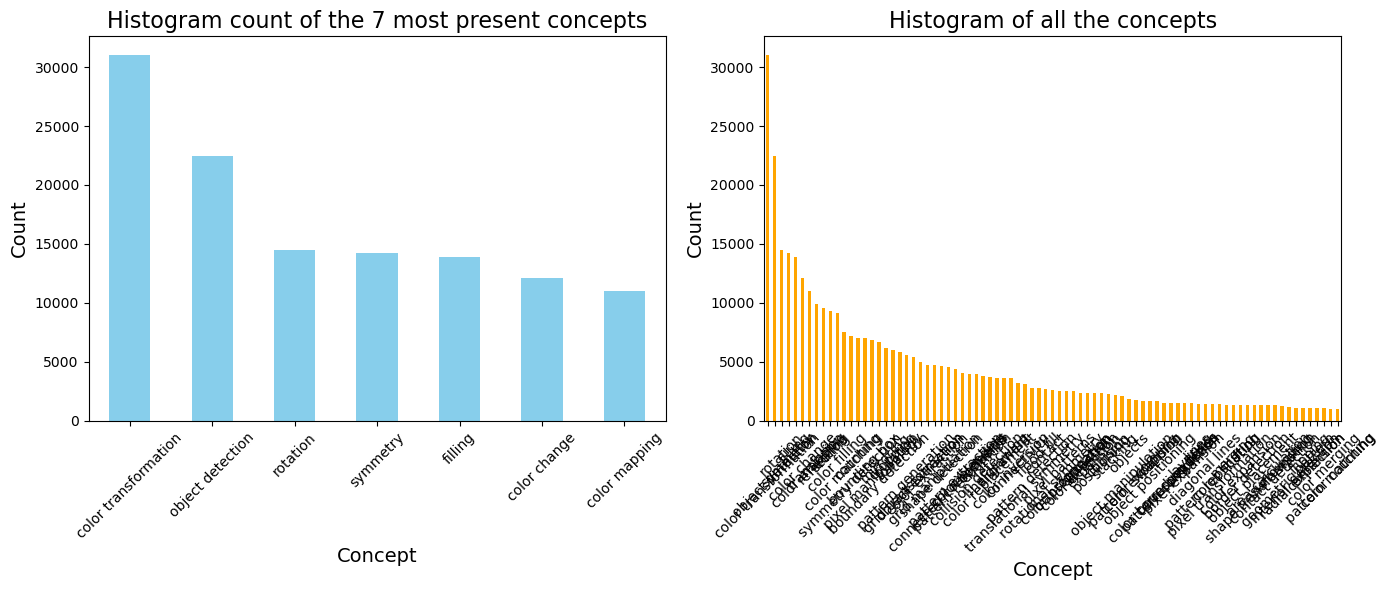

In [134]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plot 1: reduced_count_concept2
reduced_count_concept2.plot(kind="bar", ax=axes[0], color="skyblue", legend=False)
axes[0].set_title(f"Histogram count of the 7 most present concepts", fontsize=16)
axes[0].set_xlabel("Concept", fontsize=14)
axes[0].set_ylabel("Count", fontsize=14)
axes[0].tick_params(axis="x", rotation=45)

# Plot 2: reduced_count_concept
reduced_count_concept.plot(kind="bar", ax=axes[1], color="orange", legend=False)
axes[1].set_title(f"Histogram of all the concepts", fontsize=16)
axes[1].set_xlabel("Concept", fontsize=14)
axes[1].set_ylabel("Count", fontsize=14)
axes[1].tick_params(axis="x", rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

### Second Analysis when grouping concepts per categories

Demonstration on how to obtain the categories:

In [135]:
# Access the list of concepts 
reduced_list_concept = reduced_count_concept.index
# Transform it into a PandaSeries for easier manipulations
red_list_concept_series = pd.Series(reduced_list_concept, name = "Concept")

print("In the original list of 83 concepts, 18 are based on colors, 6 are object related and 4 are symmetry-related.")

subgroups = {
    "Color-Related": red_list_concept_series[red_list_concept_series.str.contains("color")],
    "Object-Related": red_list_concept_series[red_list_concept_series.str.contains("object")],
    "Symmetry-Related": red_list_concept_series[red_list_concept_series.str.contains("symmetry")]
}

for group, items in subgroups.items():
    print(f"\n{group}:")
    print(items.tolist())
    print(len(items.tolist()))

In the original list of 83 concepts, 18 are based on colors, 6 are object related and 4 are symmetry-related.

Color-Related:
['color transformation', 'color change', 'color mapping', 'color filling', 'color matching', 'color extraction', 'color blending', 'color replacement', 'color inversion', 'color propagation', 'color detection', 'color swapping', 'coloring', 'color correspondence', 'color shifting', 'color expansion', 'color merging', 'color counting']
18

Object-Related:
['object detection', 'object extraction', 'object manipulation', 'objects', 'object positioning', 'object placement']
6

Symmetry-Related:
['symmetry', 'symmetry detection', 'translational symmetry', 'rotational symmetry']
4


In [136]:
# First, invert the categories dictionary into a lookup dict for easy mapping
lookup = {}
for cat, concept_list in categories.items():
    for c in concept_list:
        lookup[c] = cat

# Now map each concept to its category
pd_concepts_melted['Category'] = pd_concepts_melted['Concept'].map(lookup)

# Sort by Index
pd_concepts_melted = pd_concepts_melted.sort_values(by="Index")

# Create Crosstab
result = pd.crosstab(pd_concepts_melted["Co"], pd_concepts_melted["Category"])

# Print 
m =len(pd_concepts_melted["Concept"][pd.isna(pd_concepts_melted["Category"])].unique())
print(f" The initial mapping is poor as only {8430 - m} concepts have been grouped in a category and {m} are still unmapped")

# Show the inital data set
pd_concepts_melted.head(10)

 The initial mapping is poor as only 78 concepts have been grouped in a category and 8352 are still unmapped


,Index,Co,Concept,Category
0,1,Concept_1,pattern detection,Pattern_and_Structure_Analysis
199728,1,Concept_2,color replacement,Color_Operations_and_Transformations
399457,2,Concept_3,color assignment,NaN
1,2,Concept_1,sorting,NaN
199729,2,Concept_2,height mapping,NaN
199730,3,Concept_2,color transformation,Color_Operations_and_Transformations
399458,3,Concept_3,object manipulation,Object_Level_Operations
2,3,Concept_1,overlapping,NaN
199731,4,Concept_2,color patterns,NaN
399459,4,Concept_3,mirroring,Geometric_and_Spatial_Transformations


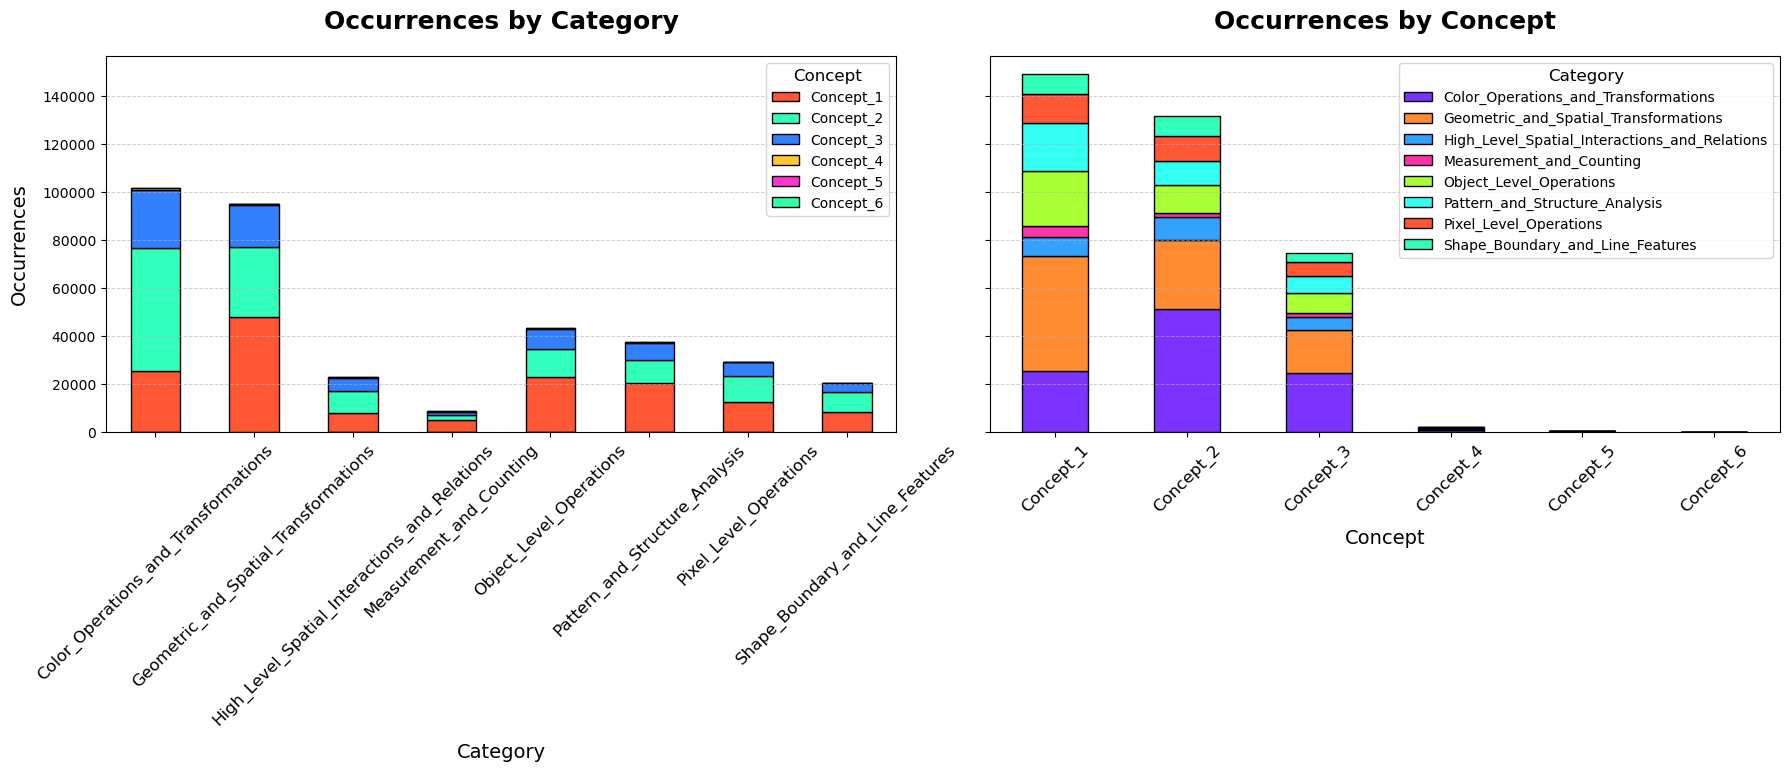

In [137]:
# Define distinct color palettes for each plot (8 colors each)
colors_grp1 = ["#FF5733", "#33FFBD", "#3380FF", "#FFC733", "#FF33D4", "#33FFA5", "#7D33FF", "#FF8C33"]
colors_grp2 = ["#7D33FF", "#FF8C33", "#33A1FF", "#FF33A8", "#A8FF33", "#33FFF2", "#FF5733", "#33FFBD"]

# Create two separate groupings
grp1 = pd_concepts_melted.groupby(["Category", "Co"]).size().unstack(fill_value=0)
grp2 = pd_concepts_melted.groupby(["Co", "Category"]).size().unstack(fill_value=0)

# Create the plots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# Styling parameters
title_font = {"fontsize": 18, "fontweight": "bold", "pad": 20}
label_font = {"fontsize": 14, "labelpad": 10}
tick_font = {"fontsize": 12}
grid_style = {"axis": "y", "linestyle": "--", "linewidth": 0.7, "alpha": 0.6}

# Plot the first group
grp1.plot(
    kind="bar",
    stacked=True,
    color=colors_grp1[:len(grp1.columns)],  # Ensure colors match the number of columns
    edgecolor="black",
    ax=axes[0]
)
axes[0].set_title("Occurrences by Category", **title_font)
axes[0].set_xlabel("Category", **label_font)
axes[0].set_ylabel("Occurrences", **label_font)
axes[0].tick_params(axis="x", rotation=45, labelsize=tick_font["fontsize"])
axes[0].grid(**grid_style)
axes[0].legend(title="Concept", title_fontsize=12, fontsize=10, loc="upper right")

# Plot the second group
grp2.plot(
    kind="bar",
    stacked=True,
    color=colors_grp2[:len(grp2.columns)],  # Ensure colors match the number of columns
    edgecolor="black",
    ax=axes[1]
)
axes[1].set_title("Occurrences by Concept", **title_font)
axes[1].set_xlabel("Concept", **label_font)
axes[1].tick_params(axis="x", rotation=45, labelsize=tick_font["fontsize"])
axes[1].grid(**grid_style)
axes[1].legend(title="Category", title_fontsize=12, fontsize=10, loc="upper right")

# Adjust layout for better spacing
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Allow space for titles and legends

# Display the plots
plt.show()


### Analysis with extensive mapping categories

In [138]:
# First, invert the categories dictionary into a lookup dict for easy mapping
lookup = {}
for cat, concept_list in categories0.items():
    for c in concept_list:
        lookup[c] = cat

# Now map each concept to its category
pd_concepts_melted['Category0'] = pd_concepts_melted['Concept'].map(lookup)

# Sort by Index
pd_concepts_melted = pd_concepts_melted.sort_values(by="Index")

# Create Crosstab
result = pd.crosstab(pd_concepts_melted["Co"], pd_concepts_melted["Category0"])

# Print 
m =len(pd_concepts_melted["Concept"][pd.isna(pd_concepts_melted["Category0"])].unique())
print(f" The initial mapping is poor as only {8430 - m} concepts have been grouped in a category and {m} are still unmapped")

# Show the inital data set
pd_concepts_melted.head(10)

 The initial mapping is poor as only 394 concepts have been grouped in a category and 8036 are still unmapped


,Index,Co,Concept,Category,Category0
0,1,Concept_1,pattern detection,Pattern_and_Structure_Analysis,Pattern and Structure Analysis & Generation
199728,1,Concept_2,color replacement,Color_Operations_and_Transformations,NaN
399457,2,Concept_3,color assignment,NaN,Color Operations and Transformations
1,2,Concept_1,sorting,NaN,NaN
199729,2,Concept_2,height mapping,NaN,"Measurement, Counting & Mapping"
199730,3,Concept_2,color transformation,Color_Operations_and_Transformations,NaN
2,3,Concept_1,overlapping,NaN,"High-Level Spatial Interactions, Relations & A..."
399458,3,Concept_3,object manipulation,Object_Level_Operations,NaN
399459,4,Concept_3,mirroring,Geometric_and_Spatial_Transformations,NaN
199731,4,Concept_2,color patterns,NaN,Color Operations and Transformations


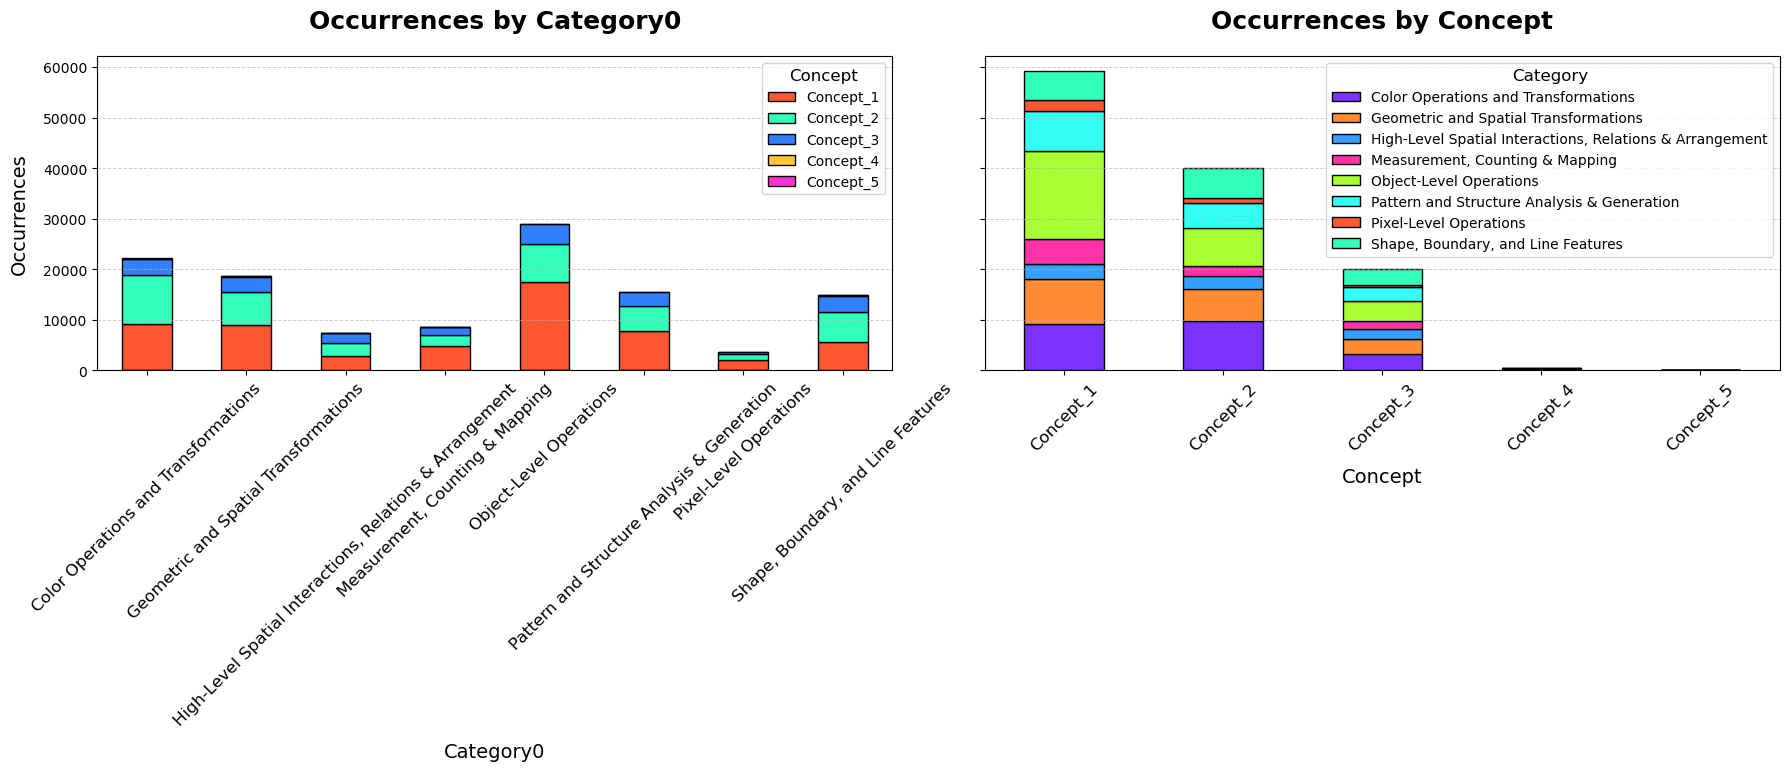

In [139]:
# Define distinct color palettes for each plot (8 colors each)
colors_grp1 = ["#FF5733", "#33FFBD", "#3380FF", "#FFC733", "#FF33D4", "#33FFA5", "#7D33FF", "#FF8C33"]
colors_grp2 = ["#7D33FF", "#FF8C33", "#33A1FF", "#FF33A8", "#A8FF33", "#33FFF2", "#FF5733", "#33FFBD"]

# Create two separate groupings
grp1 = pd_concepts_melted.groupby(["Category0", "Co"]).size().unstack(fill_value=0)
grp2 = pd_concepts_melted.groupby(["Co", "Category0"]).size().unstack(fill_value=0)

# Create the plots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# Styling parameters
title_font = {"fontsize": 18, "fontweight": "bold", "pad": 20}
label_font = {"fontsize": 14, "labelpad": 10}
tick_font = {"fontsize": 12}
grid_style = {"axis": "y", "linestyle": "--", "linewidth": 0.7, "alpha": 0.6}

# Plot the first group
grp1.plot(
    kind="bar",
    stacked=True,
    color=colors_grp1[:len(grp1.columns)],  # Ensure colors match the number of columns
    edgecolor="black",
    ax=axes[0]
)
axes[0].set_title("Occurrences by Category0", **title_font)
axes[0].set_xlabel("Category0", **label_font)
axes[0].set_ylabel("Occurrences", **label_font)
axes[0].tick_params(axis="x", rotation=45, labelsize=tick_font["fontsize"])
axes[0].grid(**grid_style)
axes[0].legend(title="Concept", title_fontsize=12, fontsize=10, loc="upper right")

# Plot the second group
grp2.plot(
    kind="bar",
    stacked=True,
    color=colors_grp2[:len(grp2.columns)],  # Ensure colors match the number of columns
    edgecolor="black",
    ax=axes[1]
)
axes[1].set_title("Occurrences by Concept", **title_font)
axes[1].set_xlabel("Concept", **label_font)
axes[1].tick_params(axis="x", rotation=45, labelsize=tick_font["fontsize"])
axes[1].grid(**grid_style)
axes[1].legend(title="Category", title_fontsize=12, fontsize=10, loc="upper right")

# Adjust layout for better spacing
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Allow space for titles and legends

# Display the plots
plt.show()


----------------------------------

In this notebook, we will

1) Transform original data set with broad categories for concepts
2) Fine-tune Llama model for classification 
3) Test it against test data set.

## 1) Transform original data set with broad categories for concepts


In [140]:
ds["train"]

Dataset({
    features: ['source', 'examples', 'seeds'],
    num_rows: 199728
})

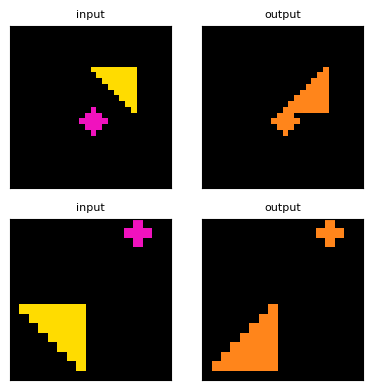

from common import *

import numpy as np
from typing import *

# concepts:
# object extraction, mirroring

# description:
# In the input, you will see a grid with a yellow triangle and a purple circle. To make the output, 
# you should extract the part of the grid that is inside the yellow triangle, mirror it over the vertical axis,
# and color it orange. 

def main(input_grid):
    # Extract the yellow triangle from the input grid
    triangle_objects = find_connected_components(input_grid, background=Color.BLACK, connectivity=4, monochromatic=True)

    # The output grid is the same size as the input grid
    output_grid = np.full_like(input_grid, Color.BLACK)

    for triangle in triangle_objects:
        # Crop the triangle to get only its pixels
        cropped_triangle = crop(triangle, background=Color.BLACK)

        # Get the dimensions of the cropped triangle
        height, width = cropped_triangle.shape

        # Create a new grid to hold the mirrored triangle
        mirro

In [141]:
examples = ds["train"][11000]["examples"]

input_output = []

# Reduce the range to 2, no purpose to observe 30
for i in range(2):
    inputgrid = np.array(examples[i][0], dtype=float)
    outputgrid = np.array(examples[i][1], dtype = float)

    input_output.append([inputgrid,outputgrid])

plot_arc_input_outputs(input_output)

print(ds["train"][11000]["source"])

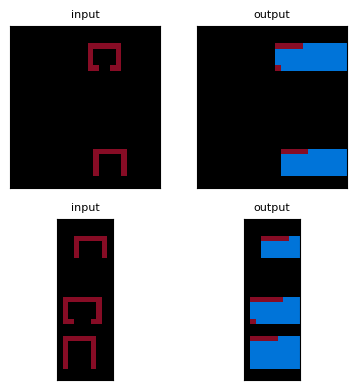

from common import *

import numpy as np
from typing import *

# concepts:
# clouds, raining

# description:
# In the input you will see several "clouds", represented as almost-enclosed shapes with a small opening at the bottom, along with empty space (black pixels) inside them.
# To make the output grid, you should fill the interior of each cloud with a specified color, then draw a line downwards from the opening of the cloud, marking the "rain" with the same color.

def main(input_grid):
    # Plan:
    # 1. Detect all the clouds
    # 2. For each cloud, find the mask of what is inside of it
    # 3. Find the opening of the cloud
    # 4. Fill the cloud with the specified color
    # 5. Draw a line downwards from the opening to represent rain
    
    # 1. Detect clouds
    cloud_objects = detect_objects(grid=input_grid, colors=[Color.MAROON], monochromatic=True, background=Color.BLACK, connectivity=4)

    output_grid = input_grid.copy()

    # For each cloud object...
    for cloud

In [142]:
examples = ds["train"][18800]["examples"]

input_output = []

# Reduce the range to 2, no purpose to observe 30
for i in range(2):
    inputgrid = np.array(examples[i][0], dtype=float)
    outputgrid = np.array(examples[i][1], dtype = float)

    input_output.append([inputgrid,outputgrid])

plot_arc_input_outputs(input_output)

print(ds["train"][18800]["source"])

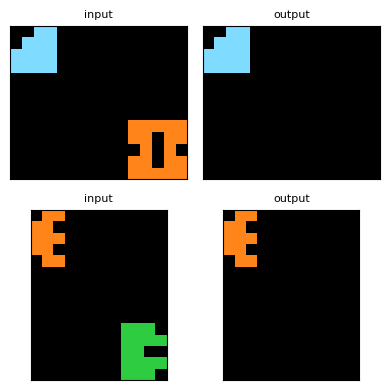

from common import *

import numpy as np
from typing import *

# concepts:
# symmetry, object merging, color blending

# description:
# In the input you will see two objects, both of which are colored and placed at opposite corners of a grid. 
# To make the output, you need to merge the two objects by blending their colors in the overlapping area, 
# which is defined as the area where the two objects can potentially overlap when they are moved towards each other.

def main(input_grid):
    # Plan:
    # 1. Detect and extract the two objects from the input grid.
    # 2. Determine their positions and potential overlapping area.
    # 3. Create a new grid and blend the colors in the overlapping area.

    background_color = Color.BLACK

    # Detect objects
    objects = detect_objects(input_grid, monochromatic=False, background=background_color, connectivity=8)

    if len(objects) != 2:
        raise ValueError("There should be exactly two objects in the input grid.")

    # Get the tw

In [143]:
k = 2958

examples = ds["train"][k]["examples"]

input_output = []

# Reduce the range to 2, no purpose to observe 30
for i in range(2):
    inputgrid = np.array(examples[i][0], dtype=float)
    outputgrid = np.array(examples[i][1], dtype = float)

    input_output.append([inputgrid,outputgrid])

plot_arc_input_outputs(input_output)

print(ds["train"][k]["source"])

There is between 4 and 59 examples per artificialy generated tasks in a 10000 sample


<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

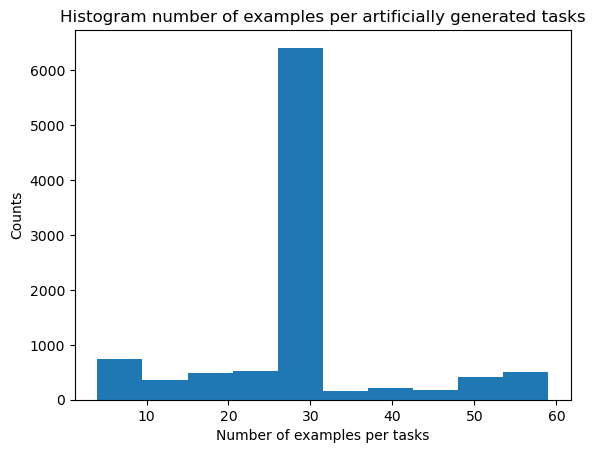

In [144]:
number_example = []
k = 5000

for i in range(k):
    number_example.append(len(ds["train"][i]["examples"]))

print(f"There is between {min(number_example)} and {max(number_example)} examples per artificialy generated tasks in a {k} sample")

plt.hist(number_example)
plt.xlabel("Number of examples per tasks")
plt.ylabel("Counts")
plt.title("Histogram number of examples per artificially generated tasks")
plt.plot

In [145]:
def extract_concepts_seeds(input_list):
    for item in input_list:
        if 'Concepts:' in item:
            # Extract the part after 'Concepts:'
            concepts_part = item.split('Concepts:')[1].strip()
            # Split the string by newline and get the first line containing the concepts
            concepts_line = concepts_part.split('\n')[0]
            # Split the concepts by commas and strip extra spaces
            concepts = [concept.strip() for concept in concepts_line.split(',')]
            return concepts
    return []

In [164]:
# Precompute the lookup dictionary once
lookup = {concept.lower(): category for category, concept_list in categories0.items() for concept in concept_list}

def extract_concepts_source(code_string):
    """
    Extracts concepts from a code string where concepts are specified in comments.

    Parameters:
        code_string (str): The code string containing concepts in comments.

    Returns:
        list: A list of concepts as strings.
    """
    concepts = []
    lines = code_string.split('\n')
    in_concepts_section = False

    for line in lines:
        if '# concepts:' in line.lower():
            in_concepts_section = True
            continue

        if in_concepts_section:
            stripped_line = line.strip('# ').strip()
            if not stripped_line:
                break
            concepts.extend([concept.strip() for concept in stripped_line.split(',')])

    return concepts

def map_concepts_to_categories(concepts):
    """
    Maps a list of concepts to higher-level categories using the precomputed lookup dictionary.

    Parameters:
        concepts (list): A list of concept strings.

    Returns:
        list: A list of corresponding higher-level categories.
    """
    return [lookup.get(concept.lower(), "Unknown Category") for concept in concepts]

In [165]:
d = extract_concepts_source(ds["train"]["source"][1])
e = map_concepts_to_categories(d)

print(d)
print(e)

['sorting', 'height mapping', 'color assignment']
['Unknown Category', 'Measurement, Counting & Mapping', 'Color Operations and Transformations']


In [170]:
# Precompute the lookup dictionary once
lookup = {concept.lower(): category for category, concept_list in categories0.items() for concept in concept_list}

def extract_concepts_source(code_string):
    """
    Extracts concepts from a code string where concepts are specified in comments.

    Parameters:
        code_string (str): The code string containing concepts in comments.

    Returns:
        list: A list of concepts as strings.
    """
    concepts = []
    lines = code_string.split('\n')
    in_concepts_section = False

    for line in lines:
        if '# concepts:' in line.lower():
            in_concepts_section = True
            continue

        if in_concepts_section:
            stripped_line = line.strip('# ').strip()
            if not stripped_line:
                break
            concepts.extend([concept.strip() for concept in stripped_line.split(',')])

    return concepts

def map_concepts_to_categories(concepts):
    """
    Maps a list of concepts to higher-level categories using the precomputed lookup dictionary.

    Parameters:
        concepts (list): A list of concept strings.

    Returns:
        list: A list of corresponding higher-level categories.
    """
    return [lookup.get(concept.lower(), "Unknown Category") for concept in concepts]

x = []
y = []

for idx, item in enumerate(ds["train"]): 

    if idx > 100000:
        break
    else:
        x.append(item.get("examples"))
        y.append(map_concepts_to_categories(extract_concepts_source(item.get("source"))))

In [ ]:
#df = pd.DataFrame({"x":x, "y": y})
#df.to_csv("Category200k(100k).csv", index = False)
#df.head(5)

,x,y
0,"[[[[1.0, 5.0, 1.0, 5.0, 1.0, 5.0, 1.0, 5.0, 1....","[Pattern and Structure Analysis & Generation, ..."
1,"[[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[Unknown Category, Measurement, Counting & Map..."
2,"[[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0....","[High-Level Spatial Interactions, Relations & ..."
3,"[[[[4.0, 6.0, 9.0, 0.0, 6.0, 9.0, 0.0, 0.0, 0....","[Unknown Category, Color Operations and Transf..."
4,"[[[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8....","[Unknown Category, Unknown Category, High-Leve..."


In [ ]:
# Transform it into a json1 file
dataset = [{"x": x_item, "y": y_item} for x_item,y_item in zip(x,y)]

In [191]:
# Save the data as a JSONL (JSON1) file
import json

with open("output.jsonl", "w") as f:
    for record in dataset:
        f.write(json.dumps(record) + "\n")


## 2) Multi-Label Classification

We will implement it in four steps,

1) Restrict labels to up to three categories
2) previous with a plan of maximum five teps
3) previous with a label of up to 10 subcategories 
4) previous with a natural Language Description of the task

Philsophy behind these choices,

- The problem is quite similar than discrete programm search with a DSL. (Under assumption that LLm perfectly translate natural language into code)
- Both rely on the assumption that it has a sequential representation, i.e. we can represent the solution under the form: $S_4^T = (3,17,50,9)$

Implications,

- We are trying to make a LLm understand the priors. 
- Like for mathematical notions, can it relate these notions to others ?

Future Questions,

- Will it understand them or only grasp a low dimensional space understanding of them ? (In another format will it be able to count, understand what is an object?)


-------------

Applies a dense layer to each pair in the sequence individually to transform each into a higher-dimensional representation.

In [180]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from datasets import load_dataset
import torch


# Set environment variable
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Clear CUDA cache
import torch
torch.cuda.empty_cache()

In [181]:
# Load model directly
tokenizer = AutoTokenizer.from_pretrained("barc0/Llama-3.1-ARC-Heavy-Induction-8B")
model = AutoModelForCausalLM.from_pretrained("barc0/Llama-3.1-ARC-Heavy-Induction-8B")

Loading checkpoint shards: 100%|██████████| 4/4 [01:03<00:00, 15.84s/it]


In [192]:
dataset = load_dataset("json", data_files={"train": "train_data.json1", "eval": "eval_data.json1"})

FileNotFoundError: Unable to find '/home/jdelinea/ARC-AGI/BARC/train_data.json1'

In [ ]:
# Tokenization function
def tokenize_function(examples):
    inputs = tokenizer(examples["prompt"], padding="max_length", truncation=True, max_length=512)
    targets = tokenizer(examples["response"], padding="max_length", truncation=True, max_length=512)
    inputs["labels"] = targets["input_ids"]
    return inputs

# Tokenize the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Training arguments
training_args = TrainingArguments(
    output_dir="./fine_tuned_llama",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    seed=42,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    fp16=True,                    # Enable mixed precision (fp16) for efficiency
    optim="adamw_torch",          # Use Adam optimizer
    report_to="tensorboard",      # Log metrics to TensorBoard
    save_total_limit=2,           # Limit the number of checkpoints saved
    push_to_hub=False,            # Set to True if pushing to Hugging Face Hub
    dataloader_num_workers=4,     # Number of workers for data loading
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["eval"],
    tokenizer=tokenizer,
)

# Train the model
trainer.train()

# Save the model and tokenizer
trainer.save_model("./fine_tuned_llama")
tokenizer.save_pretrained("./fine_tuned_llama")


AttributeError: 'NoneType' object has no attribute 'map'